In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import pandas as pd
from lc_lmfit import *

In [24]:
folder='afterglow_data/'
filename='_xray_batxrt.txt'

GRBs=['050724', '051227', '060614', '061006', '061210', '070714B', '071227', '080123', '080503', '111121A', '150424A', '211211A', '211227A']

### Extracting and Plotting Curves


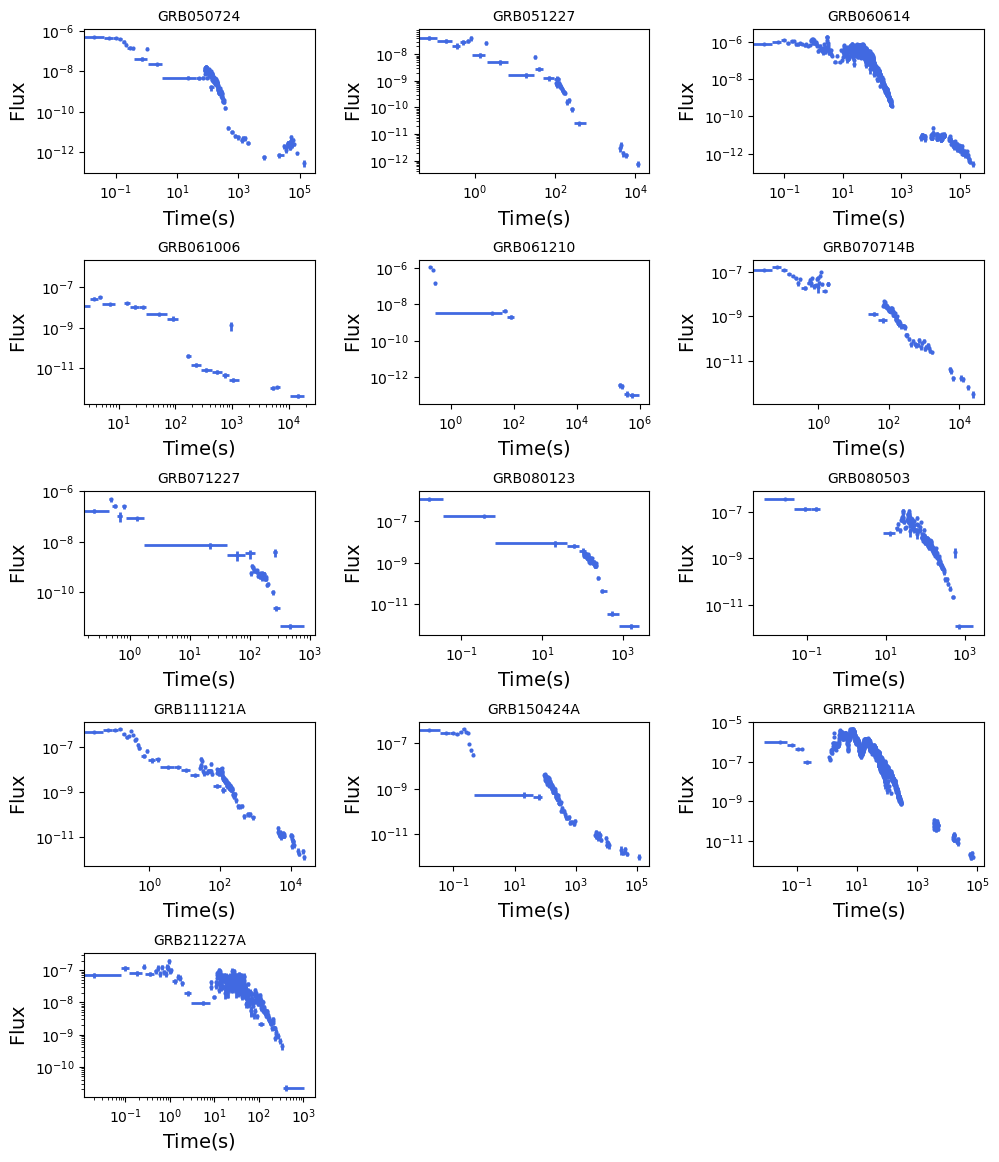

In [25]:
fig=plt.figure(figsize=(10.0,12.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.45)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(5,3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=10

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 125
    # data points      = 94
    # variables        = 4
    chi-square         = 55.1253737
    reduced chi-square = 0.61250415
    Akaike info crit   = -42.1663589
    Bayesian info crit = -31.9931798
[[Variables]]
    tb0:        94.6976701 +/- 488.694240 (516.06%) (init = 90)
    alpha_0:   -4.83957447 +/- 84.0730338 (1737.20%) (init = 0.5)
    alpha_1:    2.37026603 +/- 0.05808355 (2.45%) (init = 4)
    amplitude:  3.8799e-09 +/- 4.7458e-08 (1223.20%) (init = 1e-08)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -1.0000
    C(tb0, alpha_0)       = +0.9999
    C(alpha_0, amplitude) = -0.9999


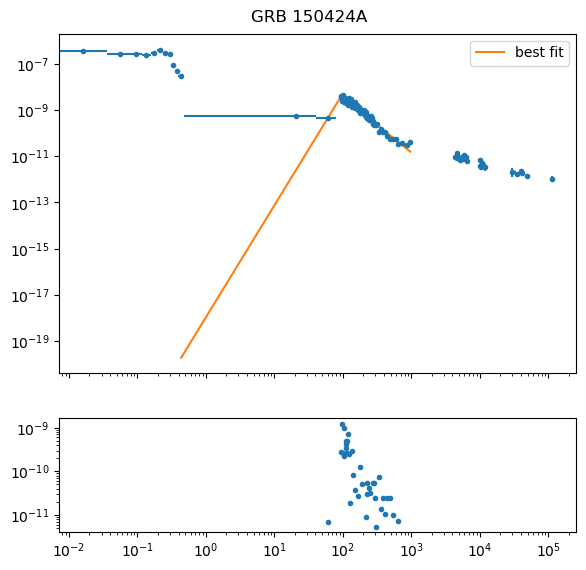

ee_start_index =  12
fit_end_index =  106
best_fit = {'tb0': 94.69767014113101, 'alpha_0': -4.839574473382635, 'alpha_1': 2.370266034404275, 'amplitude': 3.879864465744561e-09}


name,value,standard error,relative error,initial value,min,max,vary
tb0,94.6976701,488.694240,(516.06%),90,50.0000000,100.000000,True
alpha_0,-4.83957447,84.0730338,(1737.20%),0.5,-5.00000000,10.0000000,True
alpha_1,2.37026603,0.05808355,(2.45%),4,0.00000000,10.0000000,True
amplitude,3.8799e-09,4.7458e-08,(1223.20%),1e-08,1.0000e-09,1.0000e-07,True


In [26]:
i=10
n=2
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

ee_start_index = np.where(time > 0.4)[0][0]
fit_end_index = np.where(time <  1e3)[0][-1]


params=lm.Parameters()
params.add("tb0", min = 50, max = 100, value = 90)
params.add("alpha_0", min = -5, max = 10.0, value = 0.5)
params.add("alpha_1", min = 0, max = 10.0, value =4)
params.add("amplitude", min = 1e-9, max = 1e-7, value = 1e-8)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[ee_start_index:fit_end_index], flux[ee_start_index:fit_end_index], time_err[ee_start_index:fit_end_index], flux_err[ee_start_index:fit_end_index], n))
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time[ee_start_index:fit_end_index]) - flux[ee_start_index:fit_end_index]
x=np.geomspace(time[ee_start_index], time[fit_end_index])
y = get_y(result, n, x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1], sharex=True)
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x,nbroken_law(x,[107], [0.5, 4], 1e-7),label ='guess')
ax1.legend()
ax2.loglog(time[ee_start_index:fit_end_index],residuals, '.')
plt.subplots_adjust(top=0.94)
plt.suptitle("GRB "+GRBs[i])
plt.show()

print("ee_start_index = ", ee_start_index)
print("fit_end_index = ", fit_end_index)
print("best_fit =", result.params.valuesdict())

result.params

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 227
    # data points      = 100
    # variables        = 6
    chi-square         = 208.280688
    reduced chi-square = 2.21575200
    Akaike info crit   = 85.3716443
    Bayesian info crit = 101.002665
[[Variables]]
    tb0:        1.00000000 +/- 0.27565787 (27.57%) (init = 0.1)
    tb1:        142.572113 +/- 8.18617088 (5.74%) (init = 70)
    alpha_0:    3.16390012 +/- 0.38544701 (12.18%) (init = 3)
    alpha_1:    0.00680650 +/- 0.13616515 (2000.52%) (init = 0.5)
    alpha_2:    2.65247280 +/- 0.19764487 (7.45%) (init = 3)
    amplitude:  1.8191e-09 +/- 1.1170e-09 (61.40%) (init = 8e-08)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_1, amplitude) = +0.9910
    C(tb0, amplitude)     = -0.7056
    C(tb0, alpha_0)       = -0.7011
    C(tb0, alpha_1)       = -0.6977
    C(tb1, alpha_2)       = +0.5507
    C(tb1, alpha_1)       = +0.4488
    C(tb1, amplitude)     = +0.3723
    C(tb0, 

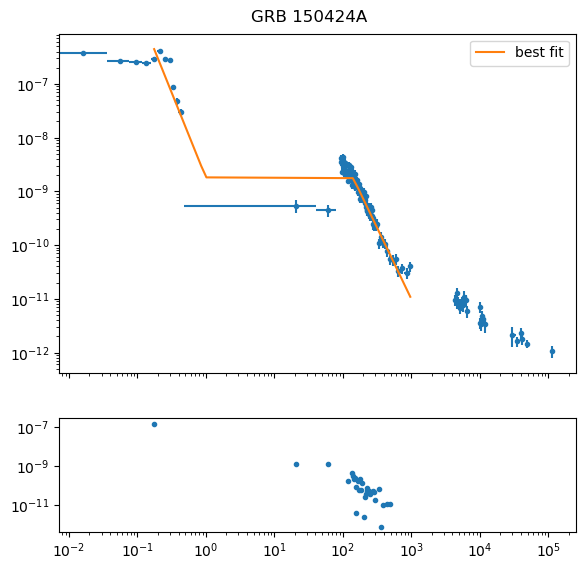

name,value,standard error,relative error,initial value,min,max,vary
tb0,1.00000000,0.27565787,(27.57%),0.1,0.00000000,1.00000000,True
tb1,142.572113,8.18617088,(5.74%),70,50.0000000,200.000000,True
alpha_0,3.16390012,0.38544701,(12.18%),3,0.00000000,10.0000000,True
alpha_1,0.00680650,0.13616515,(2000.52%),0.5,0.00000000,10.0000000,True
alpha_2,2.65247280,0.19764487,(7.45%),3,0.00000000,10.0000000,True
amplitude,1.8191e-09,1.1170e-09,(61.40%),8e-08,1.0000e-10,1.0000e-07,True


In [27]:
i=10
n=3
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

ee_start_index = np.where(time > 0.14)[0][0]
fit_end_index = np.where(time <  1e3)[0][-1]


params=lm.Parameters()
params.add("tb0", min = 0, max = 1, value = 0.1)
params.add("tb1", min = 50, max = 200, value = 70)
params.add("alpha_0", min = 0, max = 10.0, value = 3)
params.add("alpha_1", min = 0, max = 10.0, value = 0.5)
params.add("alpha_2", min = 0, max = 10.0, value = 3)
params.add("amplitude", min = 1e-10, max = 1e-7, value = 8e-8)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[ee_start_index:fit_end_index], flux[ee_start_index:fit_end_index], time_err[ee_start_index:fit_end_index], flux_err[ee_start_index:fit_end_index], n))
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time[ee_start_index:fit_end_index]) - flux[ee_start_index:fit_end_index]
x=np.geomspace(time[ee_start_index], time[fit_end_index])
y = get_y(result, n, x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1], sharex=True)
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit', zorder=10)
# ax1.loglog(x,nbroken_law(x,[0.6, 74], [4, 0, 4], 5e-8), '.', label ='guess')
ax1.legend()
ax2.loglog(time[ee_start_index:fit_end_index],residuals, '.')
plt.subplots_adjust(top=0.94)
plt.suptitle("GRB "+GRBs[i])
plt.show()


result.params

In [28]:
print("ee_start_index = ", ee_start_index)
print("fit_end_index = ", fit_end_index)
print("best_fit =", result.params.valuesdict())
standard_errors_dict = {param.name+"_err": param.stderr for param in result.params.values()}
print("errors =", standard_errors_dict)

ee_start_index =  6
fit_end_index =  106
best_fit = {'tb0': 0.9999999999999999, 'tb1': 142.5721131602082, 'alpha_0': 3.1639001243387463, 'alpha_1': 0.006806502807820101, 'alpha_2': 2.6524728037513774, 'amplitude': 1.8191486219204385e-09}
errors = {'tb0_err': 0.2756578742501138, 'tb1_err': 8.18617087790964, 'alpha_0_err': 0.3854470147682117, 'alpha_1_err': 0.13616515150275496, 'alpha_2_err': 0.19764487200789363, 'amplitude_err': 1.1170212765075066e-09}
